# Ictonyx Example 2: Model Comparison

It's common in machine learning to choose one model over another on the basis of some metric or metrics - but each model is trained _only once_.  This is analogous to a clinical trial for a new drug, with a treatment and control group consisting of one patient each.

Because model training is stochastic, it's important to consider the distribution of metrics across multiple trials.  Ictonyx makes this easy.

In this notebook, we'll train each architecture multiple times and use proper statistics to determine if Model B is *actually* better — or just got lucky.

## Setup

In [ ]:
# !pip install ictonyx tensorflow

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Input

import ictonyx as ix
from ictonyx import (
    ModelConfig, 
    KerasModelWrapper, 
    ArraysDataHandler,
    run_variability_study,
    compare_two_models,
    plot_comparison_boxplots
)

print(f"TensorFlow: {tf.__version__}")
print(f"Ictonyx: {ix.__version__}")

TensorFlow: 2.15.0
Ictonyx: 0.0.5


## Load MNIST

In [15]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype('float32') / 255.0
X_train = X_train[..., np.newaxis]

# Use subset for speed
X_subset = X_train[:10000]
y_subset = y_train[:10000]

print(f"Using {len(X_subset)} training samples")

Using 10000 training samples


## Define Two Competing Architectures

**Model A:** A shallow CNN — two conv layers, relatively few parameters.

**Model B:** A deeper CNN — three conv layers with dropout. More capacity, but also more things that can go wrong.

In [16]:
def create_shallow_cnn(config: ModelConfig) -> KerasModelWrapper:
    """Model A: Simple, shallow CNN."""
    model = Sequential([
        Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return KerasModelWrapper(model, model_id='shallow_cnn')


def create_deep_cnn(config: ModelConfig) -> KerasModelWrapper:
    """Model B: Deeper CNN with dropout."""
    model = Sequential([
        Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return KerasModelWrapper(model, model_id='deep_cnn')


# Quick comparison of parameter counts
shallow = create_shallow_cnn(ModelConfig({}))
deep = create_deep_cnn(ModelConfig({}))

print(f"Shallow CNN: {shallow.model.count_params():,} parameters")
print(f"Deep CNN: {deep.model.count_params():,} parameters")

Shallow CNN: 121,930 parameters
Deep CNN: 93,322 parameters


## Run Variability Studies for Both Models

We'll train each model 10 times and collect accuracy distributions.

In [17]:
config = ModelConfig({
    'epochs': 12,
    'batch_size': 64,
    'verbose': 0
})

data_handler = ArraysDataHandler(X_subset, y_subset)

print("Training Shallow CNN (10 runs)...")
shallow_results = run_variability_study(
    model_builder=create_shallow_cnn,
    data_handler=data_handler,
    model_config=config,
    num_runs=10,
    epochs_per_run=5
)

print("\nTraining Deep CNN (10 runs)...")
deep_results = run_variability_study(
    model_builder=create_deep_cnn,
    data_handler=data_handler,
    model_config=config,
    num_runs=10,
    epochs_per_run=5
)

Training Shallow CNN (10 runs)...
Loading and preparing data...
Array splits - Train: 7000, Val: 1000, Test: 2000
Data loaded successfully

Starting Variability Study
  Runs: 10
  Epochs per run: 5
  Execution mode: in standard mode

 - Run 1: Training...


/home/appuser/projects/ictonyx/ictonyx/memory.py:192: UserWarning: TensorFlow setup failed: Physical devices cannot be modified after being initialized
  warnings.warn(f"TensorFlow setup failed: {e}")
/home/appuser/projects/ictonyx/ictonyx/runners.py:74: UserWarning: Memory setup incomplete. Consider using process isolation for better memory control: use_process_isolation=True
  warnings.warn(


63/63 [==============================] - 0s 781us/step - loss: 0.0959 - accuracy: 0.9735
 - Run 1: Completed successfully
 - Run 2: Training...
63/63 [==============================] - 0s 888us/step - loss: 0.0910 - accuracy: 0.9720
 - Run 2: Completed successfully
 - Run 3: Training...
63/63 [==============================] - 0s 734us/step - loss: 0.0895 - accuracy: 0.9740
 - Run 3: Completed successfully
 - Run 4: Training...
63/63 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9750
 - Run 4: Completed successfully
 - Run 5: Training...
63/63 [==============================] - 0s 771us/step - loss: 0.0878 - accuracy: 0.9765
 - Run 5: Completed successfully
 - Run 6: Training...
63/63 [==============================] - 0s 772us/step - loss: 0.1087 - accuracy: 0.9715
 - Run 6: Completed successfully
 - Run 7: Training...
63/63 [==============================] - 0s 839us/step - loss: 0.0760 - accuracy: 0.9795
 - Run 7: Completed successfully
 - Run 8: Traini

/home/appuser/projects/ictonyx/ictonyx/memory.py:192: UserWarning: TensorFlow setup failed: Physical devices cannot be modified after being initialized
  warnings.warn(f"TensorFlow setup failed: {e}")
/home/appuser/projects/ictonyx/ictonyx/runners.py:74: UserWarning: Memory setup incomplete. Consider using process isolation for better memory control: use_process_isolation=True
  warnings.warn(


63/63 [==============================] - 0s 865us/step - loss: 0.0811 - accuracy: 0.9735
 - Run 1: Completed successfully
 - Run 2: Training...
63/63 [==============================] - 0s 774us/step - loss: 0.0862 - accuracy: 0.9760
 - Run 2: Completed successfully
 - Run 3: Training...
63/63 [==============================] - 0s 989us/step - loss: 0.0835 - accuracy: 0.9775
 - Run 3: Completed successfully
 - Run 4: Training...
63/63 [==============================] - 0s 742us/step - loss: 0.0801 - accuracy: 0.9770
 - Run 4: Completed successfully
 - Run 5: Training...
63/63 [==============================] - 0s 756us/step - loss: 0.0840 - accuracy: 0.9765
 - Run 5: Completed successfully
 - Run 6: Training...
63/63 [==============================] - 0s 780us/step - loss: 0.0899 - accuracy: 0.9750
 - Run 6: Completed successfully
 - Run 7: Training...
63/63 [==============================] - 0s 816us/step - loss: 0.0847 - accuracy: 0.9760
 - Run 7: Completed successfully
 - Run 8: Trai

## Compare the Results

Now we have two distributions of accuracies. Let's see if there's a statistically significant difference.

In [18]:
shallow_accs = shallow_results.final_metrics['val_accuracy']
deep_accs = deep_results.final_metrics['val_accuracy']

print("Shallow CNN:")
print(f"  Mean: {np.mean(shallow_accs):.4f}")
print(f"  Std:  {np.std(shallow_accs):.4f}")
print(f"  Range: [{np.min(shallow_accs):.4f}, {np.max(shallow_accs):.4f}]")

print("\nDeep CNN:")
print(f"  Mean: {np.mean(deep_accs):.4f}")
print(f"  Std:  {np.std(deep_accs):.4f}")
print(f"  Range: [{np.min(deep_accs):.4f}, {np.max(deep_accs):.4f}]")

Shallow CNN:
  Mean: 0.9593
  Std:  0.0033
  Range: [0.9510, 0.9630]

Deep CNN:
  Mean: 0.9675
  Std:  0.0029
  Range: [0.9620, 0.9710]


## Statistical Test

Looking at means isn't enough. We need to know if the difference is statistically significant. Ictonyx uses the Mann-Whitney U test by default, which doesn't assume normal distributions.

In [19]:
test_result = compare_two_models(
    pd.Series(shallow_accs),
    pd.Series(deep_accs)
)

print(f"Test: {test_result.test_name}")
print(f"p-value: {test_result.p_value:.4f}")
print(f"\nConclusion: {test_result.conclusion}")

Test: Independent Comparison (Student's t-test)
p-value: 0.0000

Conclusion: 


## Visualize the Comparison

A boxplot makes the overlap (or lack thereof) between the two distributions immediately clear.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


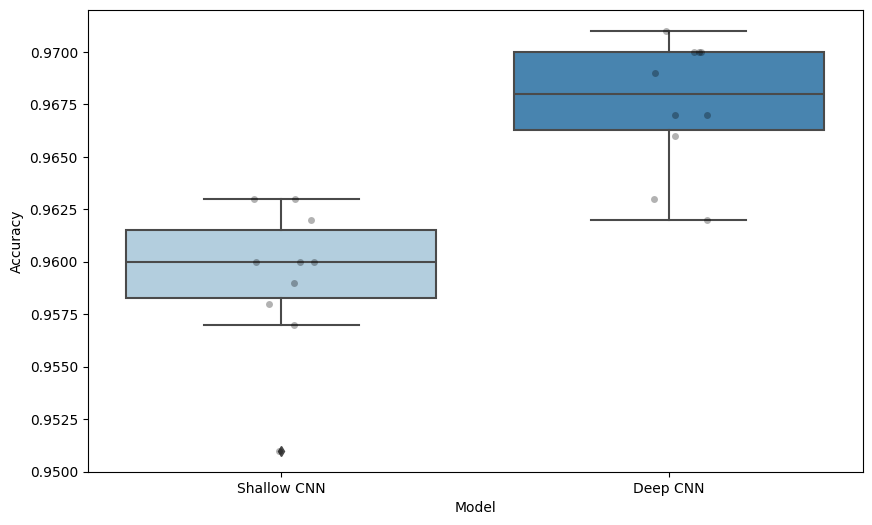

In [20]:
# Prepare data for the comparison plot
comparison_data = {
    'raw_data': {
        'Shallow CNN': shallow_accs,
        'Deep CNN': deep_accs
    }
}

plot_comparison_boxplots(comparison_data)

## Why is this important?

With a p-value less than 0.05, we can be reasonably confident that the difference is real, not just noise. If it's higher, the models might be performing similarly — and that "better" result from the deeper model might just have been a lucky run.

This is the difference between:
- "Model B got 98.7% vs Model A's 98.2%" (anecdote)
- "Model B outperforms Model A with p < 0.01" (evidence)

The second statement is what belongs in a paper, a report, or a production decision.

---

**Effect size matters too.** Even if the difference is statistically significant, it might be tiny in practical terms. A 0.1% improvement might not be worth the extra complexity. That's a judgment call — but at least now you have the data to make it.